## Gradient Descent Algorithm

<div class="alert alert-success">
    <h3>Gradient Descent Algorithm</h3>
    <ol>
        <li>Start with random initial parameters</li>
        <li>At each iteration:</li>
        <ol>
            <li>Compute the gradient of loss function w.r.t. parameters</li>
            <li>Update parameters: $W^{(new)} \leftarrow W^{(old)} - \alpha * \nabla_w L(W)$</li>
        </ol>
    </ol>
</div>

``` python
# Step1: initialize weights using small random numbers
W = 0.0001 * np.random.randn(D, C)
    
# Step 2: loop until convergence
while True:
    dW = evaluate_gradients(loss_function, X_train, y_train, W)  # dW is dL/dW
    W = W - learning_rate * dW
```

### Mini-batch gradient descent
- The gradient descent algorithm is **very inefficient** when the training data is very big.
- So, at each iteration, we use only a **small random fraction of training data (batch)**. 

<div class="alert alert-success">
    <h3>Mini-batch Gradient Descent Algorithm</h3>
    <ol>
        <li>Start with random initial parameters</li>
        <li>At each iteration:</li>
        <ol>
            <li><b>Select a batch of data randomly</b></li>
            <li>Compute the gradient of loss function w.r.t. parameters</li>
            <li>Update parameters: $W^{(new)} \leftarrow W^{(old)} - \alpha * \nabla_w L(W)$</li>
        </ol>
    </ol>
</div>

``` python
# Step1: initialize weights using small random numbers
W = 0.0001 * np.random.randn(D, C)
    
# Step 2: loop until convergence
while True:
    X_batch, y_batch = sample_training_data(X_train, y_train, batch_size=256)
    dW = evaluate_gradients(loss_function, X_batch, y_batch, W)  # dW is dL/dW
    W = W - learning_rate * dW
```

## Backpropagation
- BP is an efficient way of computing gradients automatically w.r.t. parameter, inputs and any intermediate results.
- The only requirement to use BP is that we should provide a **backward** function for each layer we define, so that this function takes the gradients with respects to its outputs and computes the gradients with respect to its inputs using **Chain Rule**.

**Chain Rule.** Let assume that $y=g(f(x))$. Then, we have:

$$\frac{dg}{dx} = \frac{dg}{df} \times \frac{df}{dx}$$

#### Forward step

```python
def affine_forward(x, w, b):
    x2d = np.reshape(x, (x.shape[0], -1))  # convert x to a 2D array
    out = np.dot(w, x2d) + b
    cache = (x, w, b)
    return out, cache
```

#### Backward Step

```python
def affine_backward(dout, cache):
    """Backward step for a linear layer.
       
       Inputs:
           - dout: the upstream dervatives; i.e., partial dervative of loss w.r.t. out.
           - cache: a tuple containing the inputs of a linear layer (x, w, b)
           
       Outputs:
           - dx: derevative of loss function w.r.t. x
           - dw: derevative of loss function w.r.t. w
           - db: derevative of loss function w.r.t. b
    """
    x, w, b = cache 
    # compute dx (dL/dx = dL/dout * dout/dx)
    # compute dW (dL/dw = dL/dout * dout/dw)
    # compute db (dL/db = dL/dout * dout/db)
    return dx, dw, db
```

### Computing gradients of loss function

$$L_i=-\log(p_{y_i}) = -\log(\frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}}) = \log(\sum_j{\exp(s_j)}) - s_{y_i}$$

#### Computing partial derevative w.r.t. $s_j$ for $j \ne y_i$

$$\frac{\partial L_i}{\partial s_j} = \frac{\exp(s_j)}{\sum_j{\exp(s_j)}} = p_j $$

#### Computing partial derevative w.r.t. $s_{y_i}$

$$\frac{\partial L_i}{\partial s_{y_i}} = \frac{\exp(s_{y_i})}{\sum_j{\exp(s_j)}} - 1 = p_{y_i} - 1$$

In [39]:
def softmax_loss(s, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    shifted_logits = s - np.max(s, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = s.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    ds = probs.copy()
    ds[np.arange(N), y] -= 1
    ds /= N
    return loss, ds

In [40]:
def svm_loss(s, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - s: Input data, of shape (N, C) where s[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    # forward step: computing data loss
    N = s.shape[0]
    correct_class_scores = s[np.arange(N), y]
    margins = np.maximum(0, s - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    
    # backward step: computing gradient of loss w.r.t. s (scores).
    num_pos = np.sum(margins > 0, axis=1)
    ds = np.zeros_like(s)
    ds[margins > 0] = 1
    ds[np.arange(N), y] -= num_pos
    ds /= N
    return loss, ds

# Putting All Together: Data + Model + Loss + Optimization

## Data: `CIFAR-10`
- Our data is ready, as we have done all necessary pre-processing steps.

In [41]:
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

('Training data shape:   ', (49000, 3072))
('Validation data shape: ', (1000, 3072))
('Test data shape:       ', (1000, 3072))
('dev data shape:        ', (500, 3072))


## Model: `linear model`
- for data $(x_i, y_i)$, compute the score using: 
$$f(x_i, W, b)=Wx_i + b$$

## Loss function: `Cross-Enropy`
- From score, compute probabilities using `softmax` function.
- Compute loss for each data using the computed probilities and its true label.

$$L_i=-\log(p_{y_i})$$

- Compute the total loss as the average over all the data losses plus regularization loss.

$$L = \frac{1}{N} \sum_{i=1}^N{L_i} + \lambda \sum_{jk}W_{jk}^2$$

**Note**: Remember to use *vectorized implementation*, which is computationally much more efficient.

## Minimize Loss Function: `Gradient Descent`

In [42]:
from layers import affine_backward

In [43]:
N = X_train.shape[0]

# define parameters for mini-batch GD
num_iterations = 1500
batch_size = 256
learning_rate = 1e-7
reg = 2.5e4

# initialize weights
W = 0.0001 * np.random.randn(3072, 10)
b = np.zeros(10)

loss_history = []

for i in range(num_iterations + 1):
    # create a batch of data
    batch_idxs = np.random.choice(N, batch_size, replace=False)
    X_batch = X_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    
    # forward step
    scores, cache = affine_forward(X_batch, W, b)
    
    # compute loss
    loss, dscores = softmax_loss(scores, y_batch)  # data loss
    loss += 0.5 * reg * np.sum(W * W)          # regularization loss
    loss_history.append(loss)
    
    # backward step
    _, dW, db = affine_backward(dscores, cache)
    dW += reg * W
      
    # report every 100 iteration
    if i % 100 == 0:
        y_preds = np.argmax(scores, axis=1)
        train_accuracy = 100.0 * np.mean(y_preds == y_batch)
        
        val_scores, _ = affine_forward(X_val, W, b)
        val_preds = np.argmax(val_scores, axis=1)
        val_accuracy = 100.0 * np.mean(val_preds == y_val)
        print("Iteration %4d: loss = %5.2f | train accuracy = %5.2f | validation accuracy = %5.2f" % 
             (i, loss, train_accuracy, val_accuracy))
    
    # update rule
    W = W - learning_rate * dW
    b = b - learning_rate * db

Iteration    0: loss =  6.19 | train accuracy = 14.45 | validation accuracy = 11.50
Iteration  100: loss =  4.44 | train accuracy = 26.56 | validation accuracy = 26.90
Iteration  200: loss =  3.45 | train accuracy = 28.52 | validation accuracy = 32.40
Iteration  300: loss =  2.93 | train accuracy = 30.86 | validation accuracy = 34.30
Iteration  400: loss =  2.50 | train accuracy = 34.38 | validation accuracy = 35.00
Iteration  500: loss =  2.33 | train accuracy = 37.50 | validation accuracy = 36.20
Iteration  600: loss =  2.20 | train accuracy = 35.16 | validation accuracy = 36.00
Iteration  700: loss =  2.10 | train accuracy = 38.67 | validation accuracy = 35.80
Iteration  800: loss =  2.10 | train accuracy = 35.94 | validation accuracy = 35.50
Iteration  900: loss =  2.06 | train accuracy = 35.55 | validation accuracy = 36.00
Iteration 1000: loss =  2.05 | train accuracy = 32.81 | validation accuracy = 36.20
Iteration 1100: loss =  2.01 | train accuracy = 32.81 | validation accuracy 

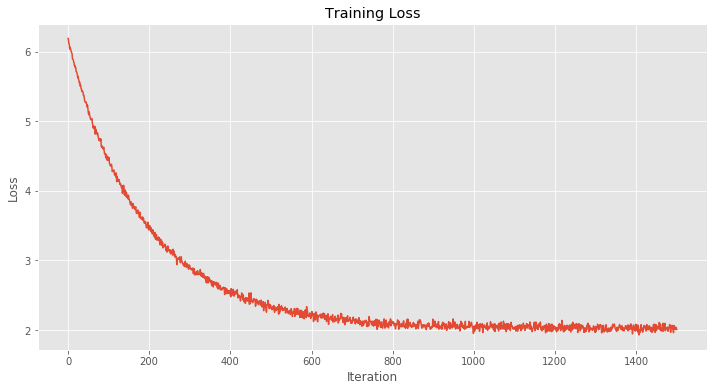

In [44]:
plt.style.use('ggplot')

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss');

### Visulalize weights

In [45]:
print(W.shape)

(3072, 10)


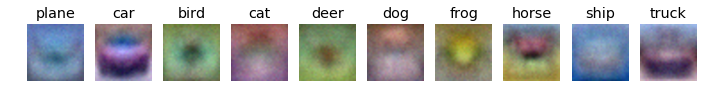

In [46]:
w_min, w_max = np.min(W), np.max(W)

for i, label in enumerate(classes):
    w = W[:, i]
    w = np.reshape(w, (32, 32, 3))
    w = 255.0 * (w - w_min) / (w_max - w_min)
    plt.subplot(1, 10, i + 1)
    plt.imshow(w.astype('uint8'), interpolation='spline16')
    plt.axis('off')
    plt.title(label)

### Prediction on test data

In [47]:
def predict(x, W, b):
    scores, _ = affine_forward(x, W, b)
    return np.argmax(scores, axis=1)

In [48]:
test_pred = predict(X_test, W, b)
test_accuracy = 100.0 * np.mean(test_pred == y_test)
print("Test accuracy = %.2f" % test_accuracy)

Test accuracy = 35.80


#### Predict labels for 10 randomly chosen test data

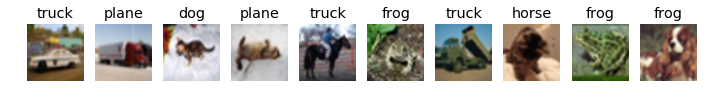

In [49]:
# choose 10 random test data
num_samples = 10
idxs = np.random.choice(X_test.shape[0], num_samples, replace=False)
X_sample, y_sample = X_test[idxs], y_test[idxs]

# predict labels
y_pred = predict(X_sample, W, b)

# To draw the picture, we should add back the mean
X_sample += mean_image

for i in range(num_samples):
    x, y = X_sample[i, :], y_sample[i]
    x = x.reshape((32, 32, 3))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x.astype('uint8'))
    plt.axis('off')
    plt.title(classes[y_pred[i]]);